In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import spacy
import re

# Introduction

# Wrangling the Data
The data used in this project comes from two Scrapy Spiders that I wrote for the [UK Essays](https://www.ukessays.com) website. They are called UK_pro_scraper and UK_student_scraper and can be found in the same github repository as this one.

### Preprocessing the UK-Student Essay Data
I've got all of the student data I could ever need, with thousands of student submitted essays to choose from. I should be able to clean them all at once. I will also make sure that this step is done in a pipeline sort of way in case I need to scrape more data. This first spider crawls a list of subjects, and each subject contains a list of links to student submissions. The student submission pages contained the entire essay. So, my student crawler went 3 pages deep for each essay. It is also important to note here that the student crawler only selected three categories: Nursing, Law, and Business. This is because the number of professional samples (samples written by the site's paid authors) was limited to just these three subjects. Fortunately, these are the three most popular subjects and there are thousands of student submissions to choose from for each essay. After each scraper was run, I pulled its json output into a dataframe and used pickle to save it. This allows me to run the scraper and my analysis separately.

In [2]:
df_student = pickle.load(open('../uk_students.pkl', 'rb'))
print('Number of student essays:', len(df_student))

# We can use this column to look at some summary statistics
df_student['joined'] = ([' '.join(each) for each in df_student.loc[:, 'text']])

df_student.head()

Number of student essays: 734


,subject,text,title,student,joined
0,Nursing,"[\n, \n, \n, \n, \n, Total Word Count: , This ...",Inquiry into Patient Death,1,\n \n \n \n \n Total Word Count: This report ...
1,Nursing,"[\n, \n, \n, \n, \n, Leadership has been descr...",Motivation Skills Development Plan for Nursing,1,\n \n \n \n \n Leadership has been described a...
2,Nursing,"[\n, \n, \n, \n, \n, Depression among pregnant...",Depression among Pregnant Adolescents: Literat...,1,\n \n \n \n \n Depression among pregnant adole...
3,Nursing,"[\n, \n, \n, \n, \n, Davidson, E., Daly, J., B...",Family Support Programme for ICU Patient Relat...,1,"\n \n \n \n \n Davidson, E., Daly, J., Brady, ..."
4,Nursing,"[\n, \n, \n, \n, \n, Idiopathic pulmonary fibr...",Idiopathic Pulmonary Fibrosis: An Overview,1,\n \n \n \n \n Idiopathic pulmonary fibrosis (...


In [3]:
lengths = pd.Series([len(each) for each in df_student.joined])
df_student['lengths'] = lengths
lengths.describe()

count      734.000000
mean     12997.242507
std       9506.293305
min         87.000000
25%       7777.750000
50%      12173.000000
75%      17417.750000
max      61642.000000
dtype: float64

Looks like we have some small essays

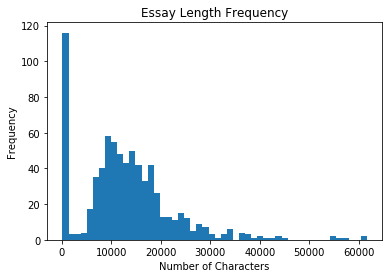

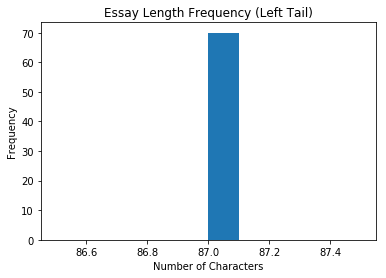

In [4]:
# I'm using a lot of bins because it is easier to see that there are a lot of very tiny essays
plt.hist(df_student.lengths, bins=50)
plt.title('Essay Length Frequency')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Let's look a little closer at the left side
plt.hist(sorted(lengths)[:70], bins=10)
plt.title('Essay Length Frequency (Left Tail)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
# plt.xlim([0, 1000])
plt.show()

Let's go ahead and throw those small essays out

In [5]:
df_student = df_student[df_student['lengths'] > 1000]
df_student.reset_index(drop=True, inplace=True)

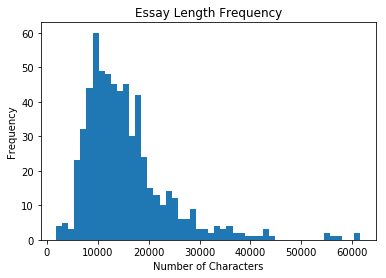

In [6]:
# I'm using a lot of bins because it is easier to see that there are a lot of very tiny essays
plt.hist(df_student.lengths, bins=50)
plt.title('Essay Length Frequency')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [7]:
df_student.joined[0][:1000]

'\n \n \n \n \n Total Word Count:  This report has been prepared for the Bunbury Regional Hospital’s quality and safety committee, following the death of Josephine Wilma Troy on 14 February 2006. Mrs. Troy was a 63 year old lady who had been diagnosed with leukemia in 2004 and was treated with chemotherapy initially. The diagnosis was later refined to prolymphocytic leukemia, a rare chronic leukemia, as Mrs. Troy’s leukemia persisted in her bone marrow after an initial course of chemotherapy. Disease together with chemotherapy compromised her blood production capacity. She had low white blood count, low platelet count and low hemoglobin and was susceptible to infection and febrile neutropenia. Mrs. Troy had been issued with febrile neutropenia card to warn health care workers regarding her susceptibility to febrile neutropenia. On 12/02/2006, Mrs. Troy had a temperature of 38°C and attended Bunbury Regional Hospital with her card. She was started on antibiotic and a full blood screen w

The paragraphs are already separated for us, there are always 5 newlines at the beginning (you'll have to take my word for it), and the last two paragraphs are always a couple random characters and a statement about exporting the document. This will be really easy to clean up.

In [8]:
for i, text in enumerate(df_student.loc[:, 'text']):
    df_student.at[i, 'text'] = text[5:-2]
df_student.head()

,subject,text,title,student,joined,lengths
0,Nursing,"[Total Word Count: , This report has been prep...",Inquiry into Patient Death,1,\n \n \n \n \n Total Word Count: This report ...,8974
1,Nursing,"[Leadership has been described as ""a relationa...",Motivation Skills Development Plan for Nursing,1,\n \n \n \n \n Leadership has been described a...,18285
2,Nursing,[Depression among pregnant adolescents as well...,Depression among Pregnant Adolescents: Literat...,1,\n \n \n \n \n Depression among pregnant adole...,15238
3,Nursing,"[Davidson, E., Daly, J., Brady, R. & Higgins, ...",Family Support Programme for ICU Patient Relat...,1,"\n \n \n \n \n Davidson, E., Daly, J., Brady, ...",10071
4,Nursing,[Idiopathic pulmonary fibrosis (IPF) is a deva...,Idiopathic Pulmonary Fibrosis: An Overview,1,\n \n \n \n \n Idiopathic pulmonary fibrosis (...,16981


### Preprocessing the UK-Professional Essay Samples
As mentioned before, there are only about 30 samples posted on their website in thier three most popular categories. We will be dealing with an imbalanced dataset, but we can deal with that when it comes time to model. Let's clean up the data and get some algorithms running.

In [9]:
# Pull in the dataframe produced by our UK_pro_scraper notebook
df_pro = pickle.load(open('../uk_pro.pkl', 'rb'))
print(df_pro.shape)
df_pro.head()

(33, 4)


,subject,text,title,student
0,nursing,"[\n, Discuss the impact of living with a long ...",Discuss the impact of living with a long term ...,0
1,nursing,"[\n, What is the Impact of Cutting down Nursin...",What is the Impact of Cutting down Nursing Stu...,0
2,nursing,"[\n, What is the Impact of Cutting down Nursin...",What is the Impact of Cutting down Nursing Stu...,0
3,nursing,"[\n, Discuss what effective leadership is and ...",Discuss what effective leadership is and argue...,0
4,law,"[\n, Case: Re: A (Children) (Conjoined Twins: ...",Case: Re: A (Children) (Conjoined Twins: Medic...,0


In [10]:
# Like before, let's see if any of these are too small
df_pro['joined'] = df_pro.text.map(' '.join) # I just (re)learned map. Map and I are going to be friends.
df_pro['lengths'] = df_pro.joined.map(len)
df_pro.head()

,subject,text,title,student,joined,lengths
0,nursing,"[\n, Discuss the impact of living with a long ...",Discuss the impact of living with a long term ...,0,\n Discuss the impact of living with a long te...,17674
1,nursing,"[\n, What is the Impact of Cutting down Nursin...",What is the Impact of Cutting down Nursing Stu...,0,\n What is the Impact of Cutting down Nursing ...,18948
2,nursing,"[\n, What is the Impact of Cutting down Nursin...",What is the Impact of Cutting down Nursing Stu...,0,\n What is the Impact of Cutting down Nursing ...,15455
3,nursing,"[\n, Discuss what effective leadership is and ...",Discuss what effective leadership is and argue...,0,\n Discuss what effective leadership is and ar...,16561
4,law,"[\n, Case: Re: A (Children) (Conjoined Twins: ...",Case: Re: A (Children) (Conjoined Twins: Medic...,0,\n Case: Re: A (Children) (Conjoined Twins: Me...,11072


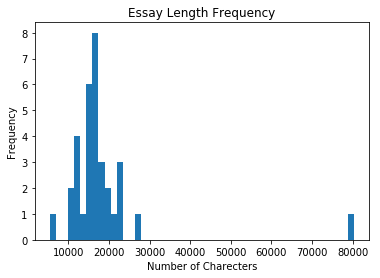

In [11]:
plt.hist(df_pro.lengths, bins=50)
plt.title('Essay Length Frequency')
plt.xlabel('Number of Charecters')
plt.ylabel('Frequency')
plt.show()

I think that everything in this dataset is worth keeping, especially because it is so small.

In [12]:
# The beginning of each example has: newline, title, newline
# We can get rid of this
[each[:3] for each in df_pro.text[:]][:5]

[['\n', 'Discuss the impact of living with a long term condition', '\n'],
 ['\n',
  'What is the Impact of Cutting down Nursing Student Bursary in the Future of Nursing Practice in the UK?',
  '\n'],
 ['\n',
  'What is the Impact of Cutting down Nursing Student Bursary in the Future of Nursing Practice in the UK?',
  '\n'],
 ['\n',
  'Discuss what effective leadership is and argue why it is deemed necessary in nursing practice',
  '\n'],
 ['\n',
  'Case: Re: A (Children) (Conjoined Twins: Medical Treatment) (No.1) [2000] 4 All ER 961.',
  '\n']]

In [13]:
# Each essay also cites sources at the end. We can get rid of those.
def find_ref_position(text):
    for i, piece in enumerate(text):
        if (piece.lower() == 'references') or (piece.lower() == 'reference'):
            return i

# Use my new friend 'map' to index where the references start
df_pro['ref_idx'] = df_pro.text.map(find_ref_position)

# Map might be good for this loop too. Looks prety skinny.
for i, text in enumerate(df_pro.text):
    try:
        # Delete everything after ref_idx
        df_pro.at[i, 'text'] = text[:int(df_pro.loc[i, 'ref_idx'])]
    except:
        pass

# Drop ref_idx. We don't need it anymore.
df_pro.drop(labels='ref_idx', axis=1, inplace=True)

# Get rid of titles, as noted before
df_pro['text'] = df_pro.text.map(lambda x: x[3:])
df_pro['joined'] = df_pro.text.map(' '.join)
df_pro.head()

,subject,text,title,student,joined,lengths
0,nursing,[There is increasing prevalence of people with...,Discuss the impact of living with a long term ...,0,There is increasing prevalence of people with ...,17674
1,nursing,"[In 2017, the government will end NHS bursarie...",What is the Impact of Cutting down Nursing Stu...,0,"In 2017, the government will end NHS bursaries...",18948
2,nursing,[This essay will critically explore the impact...,What is the Impact of Cutting down Nursing Stu...,0,This essay will critically explore the impact ...,15455
3,nursing,"[Introduction, \n, Leadership consists of vari...",Discuss what effective leadership is and argue...,0,Introduction \n Leadership consists of various...,16561
4,law,"[Notable Prior Precedents: , \n, Generally, un...",Case: Re: A (Children) (Conjoined Twins: Medic...,0,"Notable Prior Precedents: \n Generally, under...",11072


### Combining the datasets

In [14]:
df_features = df_student.loc[:, ['subject', 'joined', 'student']]
df_features = df_features.append(df_pro.loc[:, ['subject', 'joined', 'student']])

# Empty columns for processed text
df_features['tokens'] = None
df_features['lemmas'] = None
df_features.student = df_features.student.map(lambda x: 'student' if x == 1 else 'pro')
print(df_features.shape)
df_features.head()

(651, 5)


,subject,joined,student,tokens,lemmas
0,Nursing,\n \n \n \n \n Total Word Count: This report ...,student,None,None
1,Nursing,\n \n \n \n \n Leadership has been described a...,student,None,None
2,Nursing,\n \n \n \n \n Depression among pregnant adole...,student,None,None
3,Nursing,"\n \n \n \n \n Davidson, E., Daly, J., Brady, ...",student,None,None
4,Nursing,\n \n \n \n \n Idiopathic pulmonary fibrosis (...,student,None,None


# Text Cleaning and Tokenization
We've done it before but it is always necessary. We will be using the nlp text cleaner from nltk in order to utilize their lemmatizers. Also, feature engineering.

In [15]:
def text_cleaner(text):
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

nlp = spacy.load('en')

def my_lemmatizer(text):
    return ' '.join([token.lemma_ for token in text])

# I love map so much. This has changed my coding life!
df_features.joined = df_features.joined.map(text_cleaner)
df_features.tokens = df_features.joined.map(nlp)
df_features.lemmas = df_features.tokens.map(my_lemmatizer)
df_features.reset_index(drop=True, inplace=True)
df_features.head()

,subject,joined,student,tokens,lemmas
0,Nursing,Total Word Count: This report has been prepare...,student,"(Total, Word, Count, :, This, report, has, bee...",total word count : this report have be prepare...
1,Nursing,"Leadership has been described as ""a relational...",student,"(Leadership, has, been, described, as, "", a, r...","leadership have be describe as "" a relational ..."
2,Nursing,Depression among pregnant adolescents as well ...,student,"(Depression, among, pregnant, adolescents, as,...",depression among pregnant adolescent as well a...
3,Nursing,"Davidson, E., Daly, J., Brady, R. & Higgins, P...",student,"(Davidson, ,, E., ,, Daly, ,, J., ,, Brady, ,,...","davidson , e. , daly , j. , brady , r. & higgi..."
4,Nursing,Idiopathic pulmonary fibrosis (IPF) is a devas...,student,"(Idiopathic, pulmonary, fibrosis, (, IPF, ), i...",idiopathic pulmonary fibrosis ( ipf ) be a dev...


In [16]:
# Most corpora are measured in total number of words, so I'm curious to see what we are working with here
total_corpus_length = df_features.tokens.map(lambda x: len([token for token in x if not token.is_punct]))
print('Total number of words in corpus: ', total_corpus_length.sum())

Total number of words in corpus:  1577956


Not bad, 1.6 million words is a pretty decent sized corpus!

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
essays_tfidf = vectorizer.fit_transform(df_features.lemmas)
# essays_tfidf = vectorizer.fit_transform(df_features.joined)


# Getting the word list.
terms = vectorizer.get_feature_names()

You'll notice in the cell above that I tried two different ways of vectorizing the text. One with lemmatization, one without.

## Unsupervised Clustering
In this section, we will reduce dimensionality using the following unsupervised methods:
- LSA
- LDA
- NNMF
- Doc2Vec

In [101]:
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

def nlp_clean(data):
    
    new_data = []
    for d in data:
        new_str = d.lower()
        dlist = tokenizer.tokenize(new_str)
        dlist = list(set(dlist).difference(stopword_set))
        new_data.append(dlist)
    return new_data

In [102]:
class LabeledLineSentence(object):
    
    def __init__(self, doc_list, labels_list):
        
        self.labels_list = labels_list
        self.doc_list = doc_list
        
    def __iter__(self):
        # Create an iterable of TaggedDocuments
        # Don't know why, just following the documentation
        for idx, doc in enumerate(self.doc_list):
            yield gensim.models.doc2vec.TaggedDocument(doc,
                                                       [self.labels_list[idx]])

In [103]:
data = df_features.joined.tolist()
names = df_features.subject.tolist()

In [104]:
data = nlp_clean(data)

In [105]:
from gensim.models import Doc2Vec
import gensim

# Creating our document iterable here, using the yields (technically a generator?)
it = LabeledLineSentence(data, names)

# Initialize model and build vocab
model = Doc2Vec(vector_size=50, window=8, min_count=2, workers=3, alpha=0.025, min_alpha=0.005)
model.build_vocab(it)

# Training the model
model.train(it, total_examples=len(df_features), epochs=10)

model.save('doc2vec.model')

In [106]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score, pos_label='pro')
from scipy.stats import uniform as sp_uniform

X = [model.infer_vector(df_features.joined[i]) for i in range(len(df_features))]
X_train_docvec, X_test_docvec, y_train_docvec, y_test_docvec = train_test_split(X,
                                                                               df_features.student,
                                                                               test_size = 0.2)

param_dist = {'C':np.random.uniform(0.001, 1, 30)}
n_iter = 30
svc = SVC(class_weight='balanced')
svc_search = RandomizedSearchCV(svc, param_distributions=param_dist, 
                             n_iter=n_iter, scoring=f1_scorer,
                             n_jobs=-1)


svc_search.fit(X_train_docvec, y_train_docvec)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'C': array([0.07411, 0.38621, 0.3114 , 0.33881, 0.17331, 0.43725, 0.73194,
       0.7839 , 0.83781, 0.86772, 0.82353, 0.61399, 0.38531, 0.20087,
       0.60963, 0.80195, 0.50829, 0.63586, 0.17378, 0.46312, 0.50298,
       0.45909, 0.03592, 0.45887, 0.7711 , 0.33358, 0.96897, 0.96686,
       0.11097, 0.5596 ])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(f1_score, pos_label=pro), verbose=0)

In [107]:
# This function reports the top n_top results for a random search
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates[:3]:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(svc_search.cv_results_)

Model with rank: 1
Mean validation score: 0.107 (std: 0.076)
Parameters: {'C': 0.3113990088765405}

Model with rank: 1
Mean validation score: 0.107 (std: 0.076)
Parameters: {'C': 0.3388087176160448}

Model with rank: 1
Mean validation score: 0.107 (std: 0.076)
Parameters: {'C': 0.33357903156408797}

Model with rank: 4
Mean validation score: 0.093 (std: 0.067)
Parameters: {'C': 0.20086931614031248}

Model with rank: 5
Mean validation score: 0.086 (std: 0.061)
Parameters: {'C': 0.11096680807572211}



In [108]:
svc_search.best_estimator_.predict(X_test_docvec)
f1_scorer(svc_search.best_estimator_, X_test_docvec, y_test_docvec)

0.2222222222222222

In [109]:
n_components = 50

In [110]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(n_components)
lsa = make_pipeline(svd, Normalizer(copy=False))
essays_lsa = lsa.fit_transform(essays_tfidf)

In [111]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=n_components, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/n_components,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

essays_lda = lda.fit_transform(essays_tfidf) 


C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [112]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=n_components, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
essays_nmf = nmf.fit_transform(essays_tfidf) 


# Modeling
In this section, we will attempt to classify the data in as many ways as we can think of! We will also conduct a rigorous error analysis.
- Compare accuracy, f1, confusion matrix
- Try LSA,LDA, nnmf one at a time
    

In [113]:
from sklearn.model_selection import train_test_split

X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(essays_lda, 
                                                                    df_features.student, 
                                                                    test_size=0.2, 
                                                                    stratify=df_features.student)

X_train_lsa, X_test_lsa, y_train_lsa, y_test_lsa = train_test_split(essays_lsa,
                                                                    df_features.student,
                                                                    test_size=0.2,
                                                                    stratify=df_features.student)

X_train_nmf, X_test_nmf, y_train_nmf, y_test_nmf = train_test_split(essays_nmf,
                                                                    df_features.student,
                                                                    test_size=0.2,
                                                                    stratify=df_features.student)

# This is going to be a pain in the ass. I hope it actually ends up saving me time. 
# I'm going to concatenate all of these dataframes together so that I can pass them into
# a custom class, along with an estimator. The object will spit out training metrics.

# Latent Semantic Analysis
reduced_train_lsa = pd.DataFrame(data=np.append(X_train_lsa, 
                                                y_train_lsa[:, np.newaxis],
                                                1))
reduced_train_lsa['test'] = 0
reduced_test_lsa = pd.DataFrame(data=np.append(X_test_lsa, 
                                                y_test_lsa[:, np.newaxis],
                                                1))
reduced_test_lsa['test'] = 1
reduced_lsa = reduced_train_lsa.append(reduced_test_lsa, ignore_index=True)
reduced_lsa['method'] = 'lsa'
reduced_lsa.rename(columns={n_components:'target'}, inplace=True)




# Latent Dirichlet Analysis
reduced_train_lda = pd.DataFrame(data=np.append(X_train_lda, 
                                                y_train_lda[:, np.newaxis],
                                                1))
reduced_train_lda['test'] = 0
reduced_test_lda = pd.DataFrame(data=np.append(X_test_lda, 
                                                y_test_lda[:, np.newaxis],
                                                1))
reduced_test_lda['test'] = 1
reduced_lda = reduced_train_lda.append(reduced_test_lda, ignore_index=True)
reduced_lda['method'] = 'lda'
reduced_lda.rename(columns={n_components:'target'}, inplace=True)



# Non-Negative Matrix Factorization
reduced_train_nmf = pd.DataFrame(data=np.append(X_train_nmf, 
                                                y_train_nmf[:, np.newaxis],
                                                1))
reduced_train_nmf['test'] = 0
reduced_test_nmf = pd.DataFrame(data=np.append(X_test_nmf, 
                                                y_test_nmf[:, np.newaxis],
                                                1))
reduced_test_nmf['test'] = 1
reduced_nmf = reduced_train_nmf.append(reduced_test_nmf, ignore_index=True)
reduced_nmf['method'] = 'nmf'
reduced_nmf.rename(columns={n_components:'target'}, inplace=True)

# Putting it all together now:

reduced_data = reduced_lsa.copy()
reduced_data = reduced_data.append(reduced_lda, ignore_index=True)
reduced_data = reduced_data.append(reduced_nmf, ignore_index=True)
reduced_data.reset_index(inplace=True, drop=True)
# reduced_data.target = reduced_data.target.astype(np.int64) #map(lambda x: int(x))
print(reduced_data.shape[0] / 3)
reduced_data.head()

651.0


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,target,test,method
0,0.5076,-0.222073,-0.156944,0.173203,0.139829,0.022211,0.00619103,0.0893558,-0.334258,0.269251,...,0.00382073,-0.0295355,0.0303288,0.0380215,0.0406247,0.000639822,0.021515,student,0,lsa
1,0.394331,0.336423,-0.121626,-0.110311,-0.0474911,-0.279531,-0.0971384,-0.152653,-0.0387779,-0.0426864,...,0.0208433,-0.188227,-0.167972,0.0570324,0.321905,-0.2989,0.0287321,student,0,lsa
2,0.678188,-0.298743,-0.0696845,-0.337084,-0.260686,-0.0959376,0.103471,0.112424,0.0865175,0.13692,...,-0.0730429,0.0801934,-0.0190485,0.013462,0.0323057,-0.0799958,-0.0577697,student,0,lsa
3,0.606512,0.545855,-0.237608,-0.124953,0.0184046,-0.108438,0.0542704,-0.0050787,-0.047812,-0.0207432,...,-0.0241099,0.0367594,-0.0704393,-0.0344441,0.101244,0.101046,-0.0615852,student,0,lsa
4,0.227614,0.267069,-0.122655,-0.102726,-0.0213777,-0.304189,-0.118125,-0.53634,-0.195684,0.0156927,...,-0.00670929,-0.0405472,0.0312083,0.0618476,-0.00385178,0.0138755,-0.0212363,student,0,lsa


In [137]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools

class TryAllThree():
    # This class must be used with a RandomizedSearchCV object as the estimator.
    # It also requires a data frame with columns:
    # [0, 1, 2, ..., n_examples, 'target', 'test', 'method']
    def __init__(self, estimator, data):
        self.estimator = estimator
        self.data = data
        self.methods = self.data.method.unique()
        self.results = []
        
    # This method trains (fits) the classifier and then runs a
    def fit_score(self):
        test = 0
        for method in self.methods:
            self.x = self.data[(self.data['test'] == test) & 
                          (self.data['method'] == method)].iloc[:, :50]
            self.y = self.data[(self.data['test'] == test) & 
                          (self.data['method'] == method)].loc[:, 'target']
            self.estimator.fit(self.x, self.y)
            self.report(self.estimator.cv_results_, method)
            self.confusion(self.estimator, self.x, self.y)
            
            # Predict test scores using best estimator. No peaking until your done tuning!
            self.X_test = self.data[(self.data['test'] == 1) & 
                          (self.data['method'] == method)].iloc[:, :50]
            self.y_test = self.data[(self.data['test'] == 1) & 
                          (self.data['method'] == method)].loc[:, 'target']
            self.results.append((method, f1_scorer(self.estimator.best_estimator_, self.X_test, self.y_test)))
    
    # This method scores on the test data
    def score(self):
        for result in self.results:
            print('Test score for {0} method: {1}'.format(result[0], result[1]))
        
    def report(self, results, method, n_top=5):
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates[:3]:
                print("Method: {0} with rank: {1}".format(method.upper(), i))
                print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                      results['mean_test_score'][candidate],
                      results['std_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")
        
    def confusion(self, estimator, x, y):
        np.set_printoptions(precision=3)
        y_pred = estimator.best_estimator_.predict(x)
        print('Best accuracy acheived: ', accuracy_score(y, y_pred))
        print('* * * * * * * * * * * * * * * * * * * *')
        cnf_matrix = confusion_matrix(y, y_pred, labels=['pro', 'student'])
        classes = ['pro', 'student']
        plt.figure()
        self.plot_confusion_matrix(cnf_matrix, classes=classes, normalize=False)
        plt.show()
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        
        
    def plot_confusion_matrix(self, cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [138]:
# A few things we might need in the future
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_uniform

### Naive Bayes on tfidf vector

In [139]:
from sklearn.naive_bayes import MultinomialNB

param_dist = {'alpha':np.random.uniform(0.001, 10, 30)}
n_iter = 30
mnb = MultinomialNB()
mnb_search = RandomizedSearchCV(mnb, param_distributions=param_dist, 
                             n_iter=n_iter, scoring=f1_scorer,
                             n_jobs=-1)

mnb_search.fit(essays_tfidf, df_features.student)
report(mnb_search.cv_results_)

Model with rank: 1
Mean validation score: 0.056 (std: 0.079)
Parameters: {'alpha': 0.013815846135412178}

Model with rank: 2
Mean validation score: 0.000 (std: 0.000)
Parameters: {'alpha': 6.0654981890332555}

Model with rank: 2
Mean validation score: 0.000 (std: 0.000)
Parameters: {'alpha': 2.273661987584983}

Model with rank: 2
Mean validation score: 0.000 (std: 0.000)
Parameters: {'alpha': 7.611371538024304}



### LinearSVC

Method: LSA with rank: 1
Mean validation score: 0.603 (std: 0.112)
Parameters: {'C': 1.1645738940147687}

Method: LSA with rank: 1
Mean validation score: 0.603 (std: 0.112)
Parameters: {'C': 1.1323157020222667}

Method: LSA with rank: 3
Mean validation score: 0.595 (std: 0.205)
Parameters: {'C': 0.8536572522485288}

Method: LSA with rank: 3
Mean validation score: 0.595 (std: 0.205)
Parameters: {'C': 0.8635046130064389}

Method: LSA with rank: 3
Mean validation score: 0.595 (std: 0.205)
Parameters: {'C': 0.8806087977405417}

Best accuracy acheived:  0.9442307692307692
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 24   2]
 [ 27 467]]


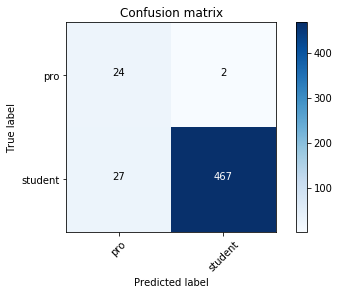

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: LDA with rank: 1
Mean validation score: 0.097 (std: 0.006)
Parameters: {'C': 0.5800289178165107}

Method: LDA with rank: 2
Mean validation score: 0.095 (std: 0.004)
Parameters: {'C': 0.08128273950611886}

Method: LDA with rank: 2
Mean validation score: 0.095 (std: 0.004)
Parameters: {'C': 1.1645738940147687}

Method: LDA with rank: 2
Mean validation score: 0.095 (std: 0.004)
Parameters: {'C': 4.628796189340523}

Best accuracy acheived:  0.46923076923076923
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 15  11]
 [265 229]]


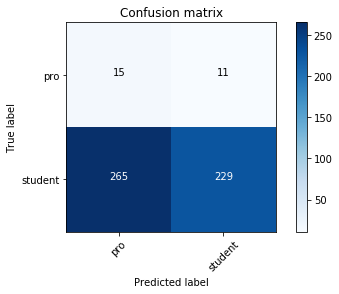

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: NMF with rank: 1
Mean validation score: 0.099 (std: 0.085)
Parameters: {'C': 0.5800289178165107}

Method: NMF with rank: 2
Mean validation score: 0.095 (std: 0.004)
Parameters: {'C': 0.08128273950611886}

Method: NMF with rank: 2
Mean validation score: 0.095 (std: 0.004)
Parameters: {'C': 1.1645738940147687}

Method: NMF with rank: 2
Mean validation score: 0.095 (std: 0.004)
Parameters: {'C': 4.628796189340523}

Best accuracy acheived:  0.9442307692307692
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[  8  18]
 [ 11 483]]


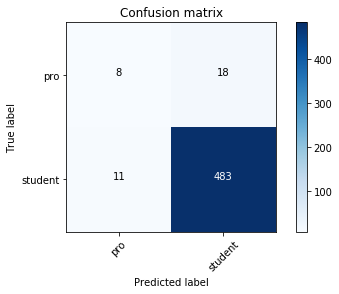

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


In [162]:
from sklearn.svm import LinearSVC

param_dist = {'C':np.random.uniform(0.001, 5, 50)}
n_iter = 50
lin_svc = SVC(class_weight='balanced')
lin_svc_search = RandomizedSearchCV(svc, param_distributions=param_dist, 
                             n_iter=n_iter, scoring=f1_scorer,
                             n_jobs=-1)

lin_svc_clf = TryAllThree(lin_svc_search, reduced_data)
lin_svc_clf.fit_score()

In [163]:
lin_svc_clf.score()

Test score for lsa method: 0.5
Test score for lda method: 0.06666666666666667
Test score for nmf method: 0.6153846153846153


### SVC

Method: LSA with rank: 1
Mean validation score: 0.614 (std: 0.220)
Parameters: {'C': 0.6831200629286194}

Method: LSA with rank: 1
Mean validation score: 0.614 (std: 0.220)
Parameters: {'C': 0.6790166795791102}

Method: LSA with rank: 3
Mean validation score: 0.607 (std: 0.222)
Parameters: {'C': 0.8955539282058824}

Method: LSA with rank: 4
Mean validation score: 0.595 (std: 0.205)
Parameters: {'C': 0.8662754350992019}

Method: LSA with rank: 5
Mean validation score: 0.588 (std: 0.133)
Parameters: {'C': 0.9747544078979401}

Best accuracy acheived:  0.9653846153846154
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 22   4]
 [ 14 480]]


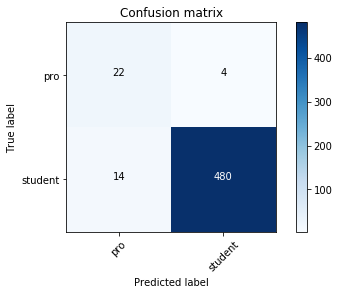

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: LDA with rank: 1
Mean validation score: 0.095 (std: 0.004)
Parameters: {'C': 0.008818324932826027}

Method: LDA with rank: 1
Mean validation score: 0.095 (std: 0.004)
Parameters: {'C': 0.25175465549397236}

Method: LDA with rank: 1
Mean validation score: 0.095 (std: 0.004)
Parameters: {'C': 0.47850452255402415}

Best accuracy acheived:  0.05
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 26   0]
 [494   0]]


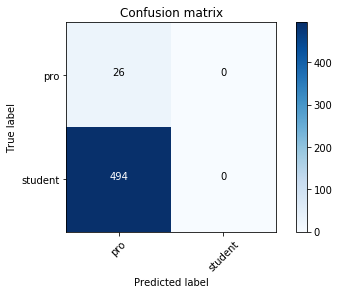

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: NMF with rank: 1
Mean validation score: 0.095 (std: 0.004)
Parameters: {'C': 0.008818324932826027}

Method: NMF with rank: 1
Mean validation score: 0.095 (std: 0.004)
Parameters: {'C': 0.25175465549397236}

Method: NMF with rank: 1
Mean validation score: 0.095 (std: 0.004)
Parameters: {'C': 0.47850452255402415}

Best accuracy acheived:  0.05
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 26   0]
 [494   0]]


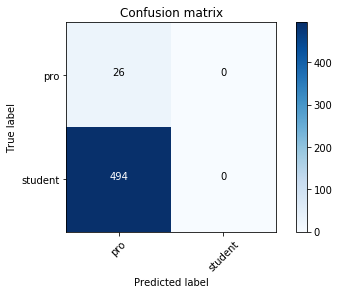

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


In [142]:
from sklearn.svm import SVC

param_dist = {'C':np.random.uniform(0.001, 1, 30)}
n_iter = 30
svc = SVC(class_weight='balanced')
svc_search = RandomizedSearchCV(svc, param_distributions=param_dist, 
                             n_iter=n_iter, scoring=f1_scorer,
                             n_jobs=-1)

svc_clf = TryAllThree(svc_search, reduced_data)
svc_clf.fit_score()

In [147]:
svc_clf.score()

Test score for lsa method: 0.5714285714285714
Test score for lda method: 0.10144927536231885
Test score for nmf method: 0.10144927536231885


### K-Nearest Neighbors

Method: LSA with rank: 1
Mean validation score: 0.500 (std: 0.082)
Parameters: {'n_neighbors': 2, 'weights': 'uniform'}

Method: LSA with rank: 2
Mean validation score: 0.500 (std: 0.124)
Parameters: {'n_neighbors': 1, 'weights': 'uniform'}

Method: LSA with rank: 2
Mean validation score: 0.500 (std: 0.124)
Parameters: {'n_neighbors': 1, 'weights': 'distance'}

Method: LSA with rank: 2
Mean validation score: 0.500 (std: 0.124)
Parameters: {'n_neighbors': 2, 'weights': 'distance'}

Method: LSA with rank: 5
Mean validation score: 0.445 (std: 0.315)
Parameters: {'n_neighbors': 3, 'weights': 'distance'}

Method: LSA with rank: 5
Mean validation score: 0.445 (std: 0.315)
Parameters: {'n_neighbors': 3, 'weights': 'distance'}

Best accuracy acheived:  0.9807692307692307
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 26   0]
 [ 10 484]]


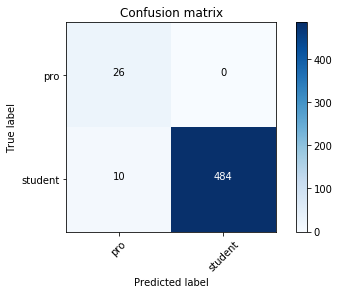

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: LDA with rank: 1
Mean validation score: 0.000 (std: 0.000)
Parameters: {'n_neighbors': 11, 'weights': 'uniform'}

Method: LDA with rank: 1
Mean validation score: 0.000 (std: 0.000)
Parameters: {'n_neighbors': 12, 'weights': 'uniform'}

Method: LDA with rank: 1
Mean validation score: 0.000 (std: 0.000)
Parameters: {'n_neighbors': 4, 'weights': 'uniform'}

Best accuracy acheived:  0.95
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[  0  26]
 [  0 494]]


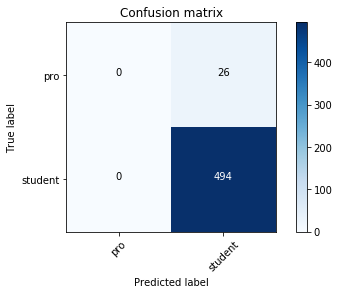

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


C:\Users\bretw\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Method: NMF with rank: 1
Mean validation score: 0.203 (std: 0.155)
Parameters: {'n_neighbors': 1, 'weights': 'distance'}

Method: NMF with rank: 1
Mean validation score: 0.203 (std: 0.155)
Parameters: {'n_neighbors': 1, 'weights': 'distance'}

Method: NMF with rank: 1
Mean validation score: 0.203 (std: 0.155)
Parameters: {'n_neighbors': 1, 'weights': 'uniform'}

Method: NMF with rank: 4
Mean validation score: 0.187 (std: 0.149)
Parameters: {'n_neighbors': 4, 'weights': 'distance'}

Method: NMF with rank: 4
Mean validation score: 0.187 (std: 0.149)
Parameters: {'n_neighbors': 4, 'weights': 'distance'}

Method: NMF with rank: 4
Mean validation score: 0.187 (std: 0.149)
Parameters: {'n_neighbors': 4, 'weights': 'distance'}

Best accuracy acheived:  1.0
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 26   0]
 [  0 494]]


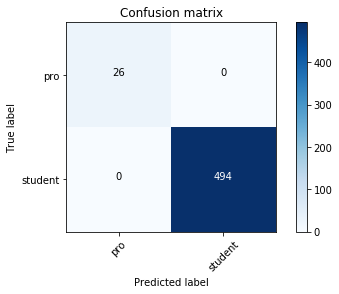

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


In [164]:
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint as sp_randint

param_dist = {'n_neighbors':sp_randint(1, 15),
              'weights':['uniform', 'distance']}
n_iter = 30
knn = KNeighborsClassifier()
knn_search = RandomizedSearchCV(knn, param_distributions=param_dist, 
                             n_iter=n_iter, scoring=f1_scorer,
                             n_jobs=-1)

knn_clf = TryAllThree(knn_search, reduced_data)
knn_clf.fit_score()

In [165]:
knn_clf.score()

Test score for lsa method: 0.5
Test score for lda method: 0.0
Test score for nmf method: 0.7142857142857143


### Random Forest

Method: LSA with rank: 1
Mean validation score: 0.409 (std: 0.064)
Parameters: {'n_estimators': 12}

Method: LSA with rank: 2
Mean validation score: 0.397 (std: 0.280)
Parameters: {'n_estimators': 5}

Method: LSA with rank: 3
Mean validation score: 0.359 (std: 0.254)
Parameters: {'n_estimators': 6}

Method: LSA with rank: 4
Mean validation score: 0.289 (std: 0.211)
Parameters: {'n_estimators': 12}

Method: LSA with rank: 4
Mean validation score: 0.289 (std: 0.211)
Parameters: {'n_estimators': 9}

Method: LSA with rank: 4
Mean validation score: 0.289 (std: 0.211)
Parameters: {'n_estimators': 12}

Best accuracy acheived:  0.9961538461538462
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 24   2]
 [  0 494]]


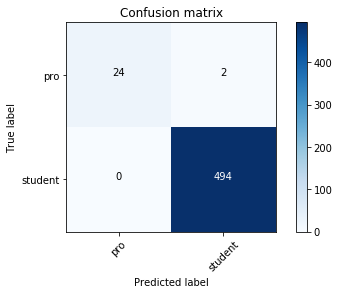

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: LDA with rank: 1
Mean validation score: 0.000 (std: 0.000)
Parameters: {'n_estimators': 6}

Method: LDA with rank: 1
Mean validation score: 0.000 (std: 0.000)
Parameters: {'n_estimators': 11}

Method: LDA with rank: 1
Mean validation score: 0.000 (std: 0.000)
Parameters: {'n_estimators': 15}

Best accuracy acheived:  0.9884615384615385
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 23   3]
 [  3 491]]


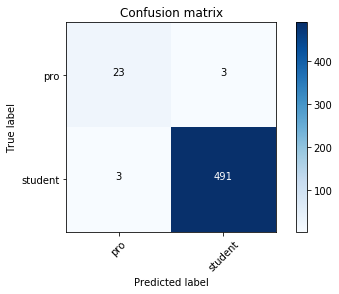

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
Method: NMF with rank: 1
Mean validation score: 0.611 (std: 0.079)
Parameters: {'n_estimators': 8}

Method: NMF with rank: 2
Mean validation score: 0.359 (std: 0.254)
Parameters: {'n_estimators': 10}

Method: NMF with rank: 3
Mean validation score: 0.348 (std: 0.131)
Parameters: {'n_estimators': 15}

Method: NMF with rank: 4
Mean validation score: 0.339 (std: 0.130)
Parameters: {'n_estimators': 8}

Method: NMF with rank: 5
Mean validation score: 0.336 (std: 0.116)
Parameters: {'n_estimators': 8}

Best accuracy acheived:  0.9980769230769231
* * * * * * * * * * * * * * * * * * * *
Confusion matrix, without normalization
[[ 25   1]
 [  0 494]]


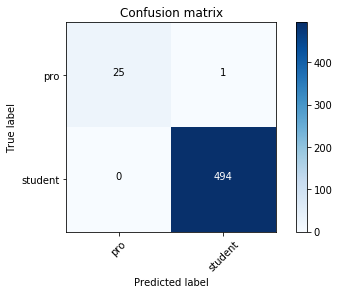

--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------


In [155]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

param_dist = {'n_estimators':sp_randint(5, 20)}
n_iter = 30
rand_for = RandomForestClassifier(class_weight='balanced')
rand_for_search = RandomizedSearchCV(rand_for, param_distributions=param_dist,
                                     n_iter=n_iter, scoring=f1_scorer,
                                     n_jobs=-1)

rand_for_clf = TryAllThree(rand_for_search, reduced_data)
rand_for_clf.fit_score()

In [156]:
rand_for_clf.score()

Test score for lsa method: 0.4444444444444445
Test score for lda method: 0.16666666666666666
Test score for nmf method: 0.22222222222222224


# Failure Analysis

# Conclusions
Self-explanatory

In [145]:
import winsound
frequency = np.random.randint(2000, 4000, 50)  # Set Frequency To 2500 Hertz
duration = 25  # Set Duration To 1000 ms == 1 second
for each in frequency:
    winsound.Beep(each, duration)

# Header